## Diffusion Pesudotime (DPT) analysis

**Inputs and Outputs**
- Inputs:
  - harmonized short-reads and long-reads adata object (raw)
  - harmonized short-reads and long-reads adata object (SCT)
  - manual (decision-tree-based) annotations of PTPRC
  - (optional) a list of splice factors
- Outputs:
  - DPT figures
  - (optional) splice factors correlated with PTPRC isoforms

In [1]:
import os
import sys

import matplotlib.pylab as plt
import colorcet as cc
import numpy as np
import pandas as pd
from time import time
import logging
import pickle
import gffutils
import pysam
import umap
import scanpy as sc
import pickle

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = print

sc.set_figure_params(dpi=80)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'

# inputs
input_prefix = 'M132TS_immune.v4.harmonized'
output_path = 'output/t-cell-vdj-cite-seq'

final_short_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.final.raw.h5ad')
final_short_adata_sct_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.final.sct.h5ad')
final_long_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.final.raw.h5ad')

# manual isoform annotation quant
manual_adata_long_annotation_quants_path = os.path.join(repo_root, 'output/t-cell-vdj-cite-seq/manual_annotations')

## Configuration

In [3]:
min_cells_per_transcript = 2
group_cells_by_obs_key = 'mehrtash_leiden'

## Preprocess

In [4]:
adata_short_sct = sc.read(final_short_adata_sct_h5_path)
adata_short_raw = sc.read(final_short_adata_raw_h5_path)

Only considering the two last: ['.sct', '.h5ad'].
Only considering the two last: ['.sct', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


In [5]:
from scipy.sparse import hstack as sparse_hstack

def extend_adata(old_adata: sc.AnnData, new_adata: sc.AnnData) -> sc.AnnData:

    old_barcodes = old_adata.obs.index.values
    old_X = old_adata.X
    new_barcodes = new_adata.obs.index.values
    new_X = new_adata.X

    new_barcodes_to_idx_map = {barcode: idx for idx, barcode in enumerate(new_barcodes)}
    assert all(barcode in new_barcodes_to_idx_map for barcode in set(old_barcodes))
    kept_new_barcode_indices = list(map(new_barcodes_to_idx_map.get, old_barcodes))
    new_X_kept = new_X[kept_new_barcode_indices, :]

    merged_var = pd.concat((old_adata.var, new_adata.var))
    try:
        merged_X = sparse_hstack((old_X, new_X_kept)).tocsr()
    except:
        merged_X = np.hstack((old_X, new_X_kept)).copy()

    merged_adata = sc.AnnData(
        X=merged_X,
        obs=old_adata.obs,
        var=merged_var,
        uns=old_adata.uns,
        obsm=old_adata.obsm)
    
    return merged_adata

In [6]:
adata_long_raw = sc.read(final_long_adata_raw_h5_path)

# extend adata with manual annotations
for dirname, _, filenames in os.walk(manual_adata_long_annotation_quants_path):
    for filename in filenames:
        manual_adata_long_path = os.path.join(dirname, filename)
        log_info(f'Adding manual isoform annotations from {manual_adata_long_path} ...')
        if manual_adata_long_path.split('.')[-1] != 'h5ad':
            continue
        manual_adata_long = sc.read(manual_adata_long_path)
        adata_long_raw = extend_adata(adata_long_raw, manual_adata_long)
adata_long_raw.X = adata_long_raw.X.tocsr()

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


Adding manual isoform annotations from /home/jupyter/mb-ml-data-disk/MAS-seq-analysis/output/t-cell-vdj-cite-seq/manual_annotations/adata_long_manual__PTPRC.h5ad ...


In [7]:
# recover raw data
adata = adata_short_sct.copy()
adata.raw = adata_short_raw
adata.X = adata.X.astype('float64')

## Preprocessing

In [8]:
n_sct_features = 5000
n_pcs = 30
n_neighbors = 100
metric = 'euclidean'

adata.var['rv'] = np.var(adata.X, axis=0)
rv_cutoff = np.sort(adata.var['rv'])[::-1][n_sct_features]
adata.var['hv'] = adata.var['rv'] > rv_cutoff
adata = adata[:, adata.var['hv']]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack', n_comps=n_pcs)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=metric)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
sc.tl.draw_graph(adata)

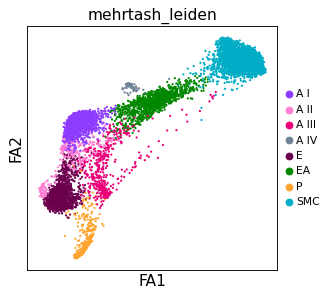

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.draw_graph(adata, color='mehrtash_leiden', legend_fontsize='x-small', ax=ax, size=16)

## (Optional) Denoising the graph

We skip this step.

In [ ]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X_diffmap')

sc.tl.draw_graph(adata)

fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.draw_graph(adata, color='mehrtash_leiden', legend_fontsize='x-small', ax=ax, size=8)

## Clustering with PAGA

In [11]:
sc.tl.paga(adata, groups='mehrtash_leiden')

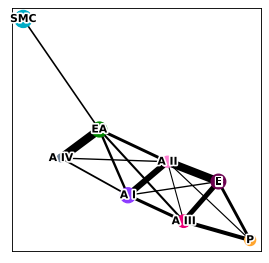

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.paga(
    adata,
    color=['mehrtash_leiden'],
    threshold=0.1,
    ax=ax,
    fontsize='x-small',
    fontoutline=3)

In [13]:
sc.tl.draw_graph(adata, init_pos='paga')

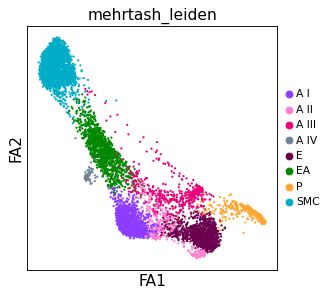

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.draw_graph(adata, color='mehrtash_leiden', legend_fontsize='x-small', ax=ax, size=16)

In [15]:
adata_paga = adata.copy()

## Difficusion Pseudotime Analysis

Adapated from https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html.  We are replacing Seurat's SCT with [Paul15] normalization recipe.

In [16]:
dpt_clusters = [
    'SMC',
    'EA',
    'A I',
    'A II',
    'E',
]

adata_dpt = adata_paga.copy()
adata_dpt = adata_dpt[adata_dpt.obs['mehrtash_leiden'].isin(dpt_clusters), :]

In [17]:
adata_dpt.uns['iroot'] = np.flatnonzero(adata_dpt.obs['mehrtash_leiden']  == 'SMC')[0]

Trying to set attribute `.uns` of view, copying.


In [18]:
sc.tl.dpt(adata_dpt)

In [19]:
adata_raw = adata_dpt.raw.to_adata()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata_dpt.raw = adata_raw

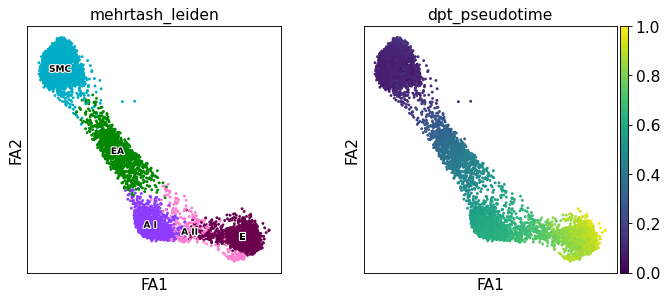

In [20]:
sc.set_figure_params(dpi=80)
sc.pl.draw_graph(adata_dpt, color=['mehrtash_leiden', 'dpt_pseudotime'], legend_loc='on data', legend_fontsize='xx-small', legend_fontoutline=2)

In [21]:
adata_dpt

AnnData object with n_obs × n_vars = 4506 × 5000
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'mehrtash_leiden', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'rv', 'hv', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'mehrtash_leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'draw_graph', 'paga', 'mehrtash_leiden_sizes', 'iroot', 'diffmap_evals'
    obsm: 'X_pca_SCT_long', 'X_pca_SCT_short', 'X_pca_raw_short', 'X_tsne', 'X_tsne_raw_short', 'X_umap_SCT_long', 'X_umap_SCT_short', 'X_pca', 'X_draw_graph_fa', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

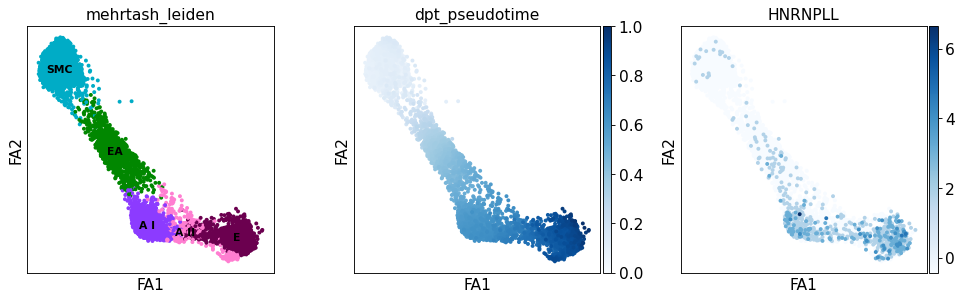

In [22]:
sc.pl.draw_graph(adata_dpt, color=['mehrtash_leiden', 'dpt_pseudotime', 'HNRNPLL'], legend_loc='on data', legend_fontsize='x-small', size=50, cmap=plt.cm.Blues)

## Add DPT coordinates to long adata

In [23]:
adata_long_dpt = adata_long_raw.copy()[adata_dpt.obs.index]
adata_long_dpt.obs['dpt_pseudotime'] = adata_dpt.obs['dpt_pseudotime']
adata_long_dpt.obsm['X_draw_graph_fa'] = adata_dpt.obsm['X_draw_graph_fa']
adata_long_dpt.uns['draw_graph'] = adata_dpt.uns['draw_graph']

Trying to set attribute `.obs` of view, copying.


In [24]:
# select isoforms for a gene
gene_name = 'PTPRC'
transcript_names = adata_long_dpt[:, adata_long_dpt.var['gene_names'] == gene_name].var.index.values.tolist()

In [25]:
# ... or select isoforms manually
transcript_names = [
    'manual__PTPRC_ABC',
    'manual__PTPRC_BC',
    'manual__PTPRC_AB',
    'manual__PTPRC_B',
    'manual__PTPRC_O',
]

transcript_names_in_fig = [
    'CD45RABC',
    'CD45RBC',
    'CD45RAB',
    'CD45RB',
    'CD45RO',
]

# genes to show total expression alongside the isoforms
gene_names = ['HNRNPLL']

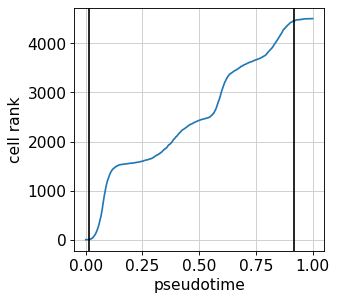

In [26]:
# define pseudotime range for plotting
sorted_pseudotime = np.sort(adata_long_dpt.obs['dpt_pseudotime'].values)
min_pseudotime = sorted_pseudotime[int(0.001 * len(sorted_pseudotime))]
max_pseudotime = sorted_pseudotime[int(0.99 * len(sorted_pseudotime))]
plt.plot(sorted_pseudotime, np.arange(len(sorted_pseudotime)))
plt.xlabel('pseudotime')
plt.ylabel('cell rank')
plt.axvline(min_pseudotime, color='black')
plt.axvline(max_pseudotime, color='black')

... storing 'transcript_ids' as categorical
... storing 'gene_ids' as categorical
... storing 'gene_names' as categorical
... storing 'de_novo_gene_ids' as categorical
... storing 'gencode_overlap_gene_names' as categorical
... storing 'gencode_overlap_gene_ids' as categorical


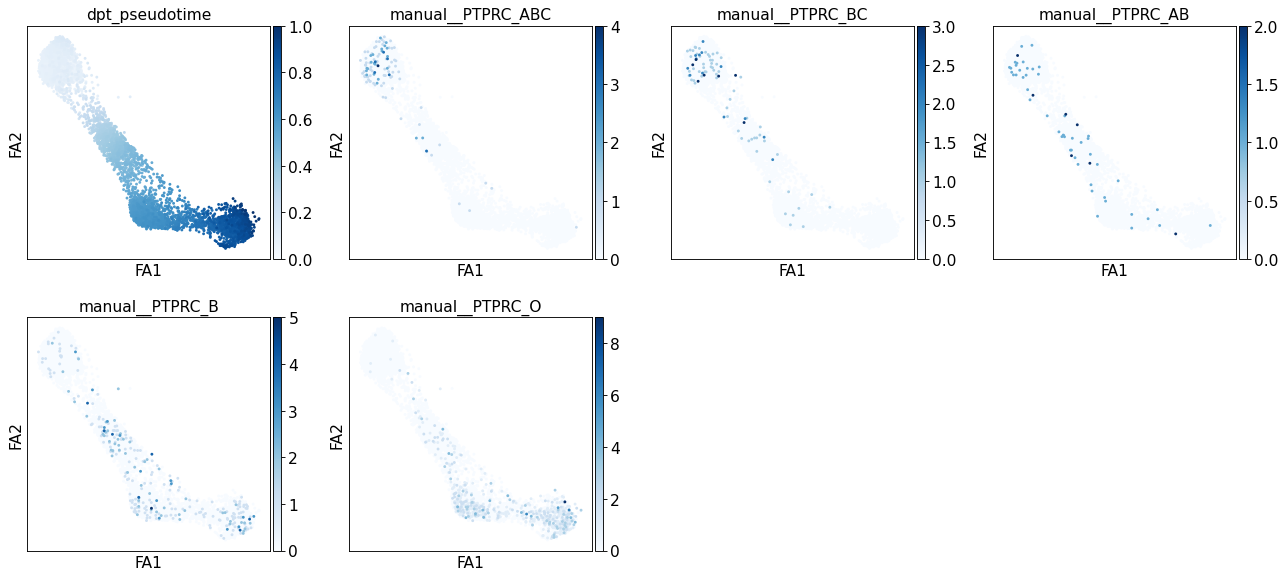

In [27]:
sc.set_figure_params(dpi=80)
sc.pl.draw_graph(adata_long_dpt, color=['dpt_pseudotime'] + transcript_names, legend_loc='on data', legend_fontsize='xx-small', cmap=plt.cm.Blues)

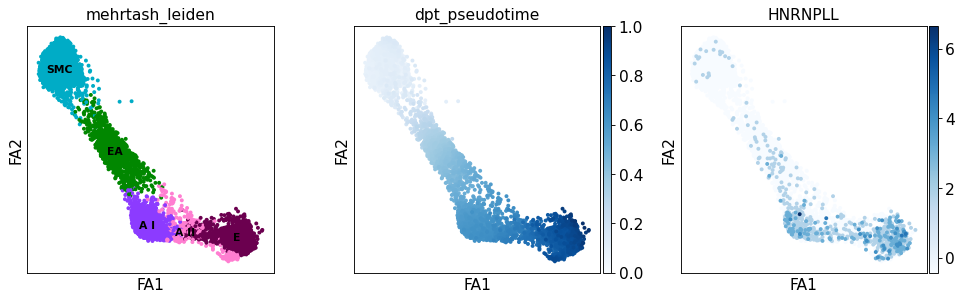

In [28]:
sc.pl.draw_graph(
    adata_dpt,
    color=['mehrtash_leiden', 'dpt_pseudotime'] + gene_names,
    legend_loc='on data',
    legend_fontsize='x-small',
    size=50,
    cmap=plt.cm.Blues)

## Generate expression gradient bars along pseudotime

In [29]:
from sklearn.neighbors import KNeighborsRegressor

def gaussian_kernel(distances, width):
    return np.exp(-distances**2 / width**2)

def get_kr_smooth(x, y, n_neighbors=50, kernel_width=0.1, x_plot=None):
    if x_plot is None:
        x_plot = x
    good_indices = np.isfinite(x)
    x = x[good_indices]
    y = y[good_indices]
    weights = lambda distances: gaussian_kernel(distances, kernel_width)
    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    reg.fit(x[:, None], y)
    y_knn = reg.predict(x_plot[:, None]) 
    return y_knn

In [30]:
# constants
GENE_IDS_KEY = 'gencode_overlap_gene_ids'
GENE_NAMES_KEY = 'gencode_overlap_gene_names'

# mapping from gene id to spanning tx icatces
from collections import defaultdict
gene_id_to_tx_indices_map = defaultdict(list)
for i, gid in enumerate(adata_long_raw.var[GENE_IDS_KEY].values):
    if isinstance(gid, str):
        gene_id_to_tx_indices_map[gid].append(i)

# useful auxiliary data structures    
gene_ids = sorted(list(gene_id_to_tx_indices_map.keys()))
n_genes = len(gene_ids)
n_transcripts = adata_long_raw.shape[1]
gene_id_to_gene_name_map = {
    gene_id: gene_name for gene_id, gene_name in zip(adata_long_raw.var[GENE_IDS_KEY], adata_long_raw.var[GENE_NAMES_KEY])}
gene_name_to_gene_id_map = {
    gene_name: gene_id for gene_id, gene_name in zip(adata_long_raw.var[GENE_IDS_KEY], adata_long_raw.var[GENE_NAMES_KEY])}

In [31]:
import scipy

# get gene expression from isoform expression
row_indices = []
col_indices = []
values = []
for j, gene_id in enumerate(gene_ids):
    tx_indices = gene_id_to_tx_indices_map[gene_id]
    row_indices += tx_indices
    col_indices += [j] * len(tx_indices)
    values += [1] * len(tx_indices)
Y_ij = scipy.sparse.coo_matrix((values, (row_indices, col_indices)), shape=(n_transcripts, n_genes)).tocsr()
gex_X_nj = adata_long_raw.X @ Y_ij

# normalize
adata_long_gex = sc.AnnData(
    X=gex_X_nj,
    obs=adata_long_raw.obs,
    var=pd.DataFrame(index=pd.Index(list(map(gene_id_to_gene_name_map.get, gene_ids)))))

adata_long_gex.var_names_make_unique()
adata_long_gex = adata_long_gex[adata_long_dpt.obs.index].copy()
# sc.pp.normalize_per_cell(adata_long_gex)
# sc.pp.log1p(adata_long_gex)

adata_short_gex = adata_short_raw[adata_long_dpt.obs.index].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [32]:
# for normalization
log1p_transform = False
simplex_transform = False
normalize_separately = True
final_trans = lambda x: np.power(x, 0.8)

# for smoothing and plotting
kernel_width = 0.01
x_plot_num_points = 1000

adata_gex = adata_short_gex

n_neighbors = adata_long_dpt.shape[0] - 1

heatmaps = []
x = adata_long_dpt.obs['dpt_pseudotime'].values

for transcript_name in transcript_names:
    
    # get the raw isoform expression counts
    try:
        y = np.asarray(adata_long_dpt[:, adata_long_dpt.var.index.values == transcript_name].X.todense()).flatten()
    except:
        y = adata_long_dpt[:, adata_long_dpt.var.index.values == transcript_name].X.flatten().copy()
    
    # transform
    if log1p_transform:
        y = np.log1p(y)
    
    x_plot = np.linspace(min_pseudotime, max_pseudotime, num=x_plot_num_points)
    y_smooth = get_kr_smooth(x, y, x_plot=x_plot, n_neighbors=n_neighbors, kernel_width=kernel_width)
    heatmaps.append(y_smooth)


for gene_name in gene_names:
    
    # get the raw isoform expression counts
    try:
        y = np.asarray(adata_gex[:, adata_gex.var.index.values == gene_name].X.todense()).flatten()
    except:
        y = adata_gex[:, adata_gex.var.index.values == gene_name].X.flatten().copy()
    
    # transform
    if log1p_transform:
        y = np.log1p(y)
    
    x_plot = np.linspace(min_pseudotime, max_pseudotime, num=x_plot_num_points)
    y_smooth = get_kr_smooth(x, y, x_plot=x_plot, n_neighbors=n_neighbors, kernel_width=kernel_width)
    heatmaps.append(y_smooth)

heatmaps = np.asarray(heatmaps)

heatmap_tx_inds = np.arange(0, len(transcript_names))
heatmap_gene_inds = np.arange(len(transcript_names), len(transcript_names) + len(gene_names))

if simplex_transform:
    heatmaps[heatmap_tx_inds] = heatmaps[heatmap_tx_inds] / (
        np.sum(heatmaps[heatmap_tx_inds], 0)[None, :] + 1e-12)
    
if normalize_separately:
    heatmaps[heatmap_tx_inds] = heatmaps[heatmap_tx_inds] / (
        np.max(heatmaps[heatmap_tx_inds], axis=1)[:, None] + 1e-12)

heatmaps[heatmap_gene_inds] = heatmaps[heatmap_gene_inds] / (
    np.max(heatmaps[heatmap_gene_inds], axis=1)[:, None] + 1e-12)

heatmaps = final_trans(heatmaps)

In [33]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return np.asarray(tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))) / 255.

leiden_id_to_leiden_color_map = {
    adata_long_dpt.obs['mehrtash_leiden'].values.categories[i]: hex_to_rgb(adata_long_dpt.uns['mehrtash_leiden_colors'][i])
    for i in range(len(adata_long_dpt.obs['mehrtash_leiden'].values.categories))}

cell_colors_nc = np.asarray(list(map(leiden_id_to_leiden_color_map.get, adata_long_dpt.obs['mehrtash_leiden'].values)))

cluster_img_xc = np.zeros((len(x_plot), 3))
pt_array = adata_long_dpt.obs['dpt_pseudotime'].values
k = 5
for i, pt in enumerate(x_plot):
    indices = np.argsort(np.abs(pt_array - pt))
    color = np.mean(cell_colors_nc[indices][:k], axis=0)
    cluster_img_xc[i] = color

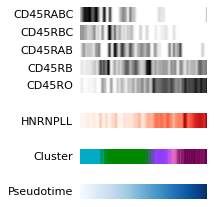

In [34]:
# Create figure and adjust figure height to number of colormaps
nrows = len(transcript_names) + len(gene_names) + 4
figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
fig, axs = plt.subplots(nrows=nrows + 1, figsize=(2, figh))
fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                    left=0.2, right=0.99)

max_value = np.max(heatmaps)
min_value = np.min(heatmaps)
heatmap_sum = np.asarray(heatmaps).sum(0)

n = len(transcript_names_in_fig)
for ax, name, heatmap in zip(axs[:n], transcript_names_in_fig, heatmaps[:n]):
    img = np.vstack((heatmap, heatmap))
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray_r, vmin=0., vmax=max_value)
    ax.text(-0.05, 0.5, name, va='center', ha='right', fontsize=10,
            transform=ax.transAxes)

m = len(gene_names)
for ax, name, heatmap in zip(axs[(n + 1):(n + m + 1)], gene_names, heatmaps[n:(n + m)]):
    img = np.vstack((heatmap, heatmap))
    vmax = np.max(heatmap)
    vmax = max_value
    ax.imshow(img, aspect='auto', cmap=plt.cm.Reds, vmin=0, vmax=vmax)
    ax.text(-0.05, 0.5, name, va='center', ha='right', fontsize=10,
            transform=ax.transAxes)

# cluster
ax = axs[-3]
img = np.vstack((cluster_img_xc[None, ...], cluster_img_xc[None, ...]))
ax.imshow(img, aspect='auto')
ax.text(-0.05, 0.5, 'Cluster', va='center', ha='right', fontsize=10, transform=ax.transAxes)

# pseudotime
ax = axs[-1]
img = np.vstack((x_plot, x_plot))
ax.imshow(img, aspect='auto', cmap=plt.cm.Blues, vmin=min_pseudotime, vmax=max_pseudotime)
ax.text(-0.05, 0.5, 'Pseudotime', va='center', ha='right', fontsize=10, transform=ax.transAxes)
    
# Turn off *all* ticks & spines, not just the ones with colormaps.
for ax in axs:
    ax.set_axis_off()
    
plt.savefig('./output/M132TS__pseudotime__PTPRC.pdf', bbox_inches="tight")

## Make final plots

In [35]:
def plot_embedding_leiden(
        adata: sc.AnnData,
        embedding_key: str,
        leiden_key: str,
        markersize=2,
        alpha=0.75,
        xlabel='UMAP1',
        ylabel='UMAP2',
        label_kwargs=dict(bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)),
        x_offset=dict(),
        y_offset=dict(),
        fig=None,
        ax=None,
        show_labels=True,
        figsize=(3, 3)):
    
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    leiden_color_key = f'{leiden_key}_colors'
    assert leiden_color_key in set(adata.uns.keys())

    leiden_category_to_leiden_color_map = {
        leiden_category: leiden_color
        for leiden_color, leiden_category in zip(
            adata.uns[leiden_color_key],
            adata.obs[leiden_key].values.categories)}
    cell_color_list = list(
        map(leiden_category_to_leiden_color_map.get, adata.obs[leiden_key]))

    ax.scatter(
        adata.obsm[embedding_key][:, 0],
        adata.obsm[embedding_key][:, 1],
        color=cell_color_list,
        s=markersize,
        alpha=alpha)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if show_labels:
        for leiden_category in adata.obs[leiden_key].values.categories:
            try:
                dx = x_offset[leiden_category]
                dy = y_offset[leiden_category]
            except KeyError:
                dx = 0
                dy = 0
            x_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 0] + dx
            y_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 1] + dy
            x_c, y_c = np.mean(x_values), np.mean(y_values)
            ax.text(
                x_c, y_c, leiden_category,
                fontsize=8,
                ha='center',
                **label_kwargs)

def plot_embedding_continuous(
        adata: sc.AnnData,
        embedding_key: str,
        values: np.ndarray,
        cmap=plt.cm.Blues,
        markersize=2,
        alpha=0.75,
        xlabel='UMAP1',
        ylabel='UMAP2',
        fig=None,
        ax=None,
        sort=True,
        figsize=(3, 3),
        **kwargs):
    
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    if sort:
        order = np.argsort(values)
    else:
        order = np.arange(len(values))
    scatter = ax.scatter(
        adata.obsm[embedding_key][order, 0],
        adata.obsm[embedding_key][order, 1],
        c=values[order],
        cmap=cmap,
        s=markersize,
        alpha=alpha,
        **kwargs)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return scatter

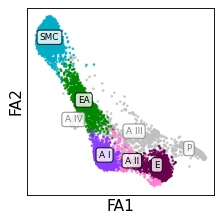

In [36]:
fig, ax = plt.subplots(figsize=(3, 3))

excluded_clusters = list(set(adata.obs['mehrtash_leiden'].values.categories).difference(set(dpt_clusters)))
adata_excluded = adata[adata.obs['mehrtash_leiden'].values.isin(excluded_clusters), :].copy()
adata_excluded.uns['mehrtash_leiden_colors'] = ['#c0c0c0'] * len(excluded_clusters)

plot_embedding_leiden(
    adata_excluded,
    'X_draw_graph_fa',
    'mehrtash_leiden',
    xlabel='FA1',
    ylabel='FA2',
    label_kwargs=dict(
        color='gray',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8)),
    ax=ax,
    fig=fig
)

plot_embedding_leiden(
    adata_dpt,
    'X_draw_graph_fa',
    'mehrtash_leiden',
    xlabel='FA1',
    ylabel='FA2',
    ax=ax,
    fig=fig
)

fig.tight_layout()
plt.savefig('./output/M132TS__FA__clusters.pdf')

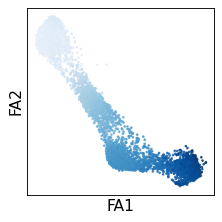

In [37]:
import sklearn

fig, ax = plt.subplots(figsize=(3, 3))

plot_embedding_continuous(
    adata_dpt,
    'X_draw_graph_fa',
    adata_dpt.obs['dpt_pseudotime'],
    xlabel='FA1',
    ylabel='FA2',
    ax=ax,
    fig=fig)

fig.tight_layout()
plt.savefig('./output/M132TS__FA__pseudotime.pdf')

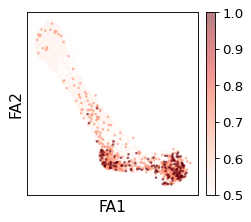

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(3, 3))

gene_name = 'HNRNPLL'
gex = np.log1p(np.asarray(adata_short_raw[adata_dpt.obs.index, adata_short_raw.var.index == gene_name].X.todense()).flatten())
scatter = plot_embedding_continuous(
    adata_dpt,
    'X_draw_graph_fa',
    values=gex,
    xlabel='FA1',
    ylabel='FA2',
    ax=ax,
    fig=fig,
    vmin=0.5,
    vmax=1,
    alpha=0.5,
    cmap=plt.cm.Reds
)

div = make_axes_locatable(ax)
color_axis = div.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter, cax=color_axis)
cbar.ax.tick_params(labelsize=12) 

plt.savefig('./output/M132TS__FA__HNRNPLL.pdf', bbox_inches="tight")

## Correltion analysis between splicing factors and pseudotime

In [39]:
# load annotations
splicing_factor_df = pd.read_csv(
    os.path.join(
        repo_root,
        'resources/QuickGO-annotations-1625175581785-20210701.tsv'),
    delimiter='\t')

splicing_factor_gene_symbols = np.unique(splicing_factor_df['SYMBOL'].values)
expressed_splicing_factor_gene_symbols = list(set(splicing_factor_gene_symbols).intersection(adata_raw.var.index.values))
expressed_splicing_factor_df = splicing_factor_df.iloc[
    splicing_factor_df['SYMBOL'].isin(expressed_splicing_factor_gene_symbols).values]
print(f'Expressed splicing factors: {len(expressed_splicing_factor_gene_symbols)}')

Expressed splicing factors: 646


In [40]:
adata_corr = adata_short_raw.copy()
sc.pp.normalize_total(adata_corr)
sc.pp.log1p(adata_corr)

pt_array = adata_long_dpt.obs['dpt_pseudotime'].values

In [41]:
def plot_correlation(gene_name: str):
    
    x_plot_num_points = 1000
    n_neighbors = adata_dpt.shape[0]
    kernel_width = 0.02

    gex_array = np.asarray(adata_corr[adata_dpt.obs.index, adata_corr.var.index == gene_name].X.todense()).flatten()

    x_plot = np.linspace(0., 1., num=x_plot_num_points)
    y_smooth = get_kr_smooth(pt_array, gex_array, x_plot=x_plot, n_neighbors=n_neighbors, kernel_width=kernel_width)
    
    fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
    
    ax = axs[0]
    ax.plot(x_plot, y_smooth)
    ax.set_xlabel('Pseudotime')
    ax.set_ylabel('Smoothed expression')
    ax.set_title(gene_name)
    
    ax = axs[1]
    scatter = plot_embedding_continuous(
        adata_dpt,
        'X_draw_graph_fa',
        values=gex_array,
        xlabel='FA1',
        ylabel='FA2',
        ax=ax,
        fig=fig,
        alpha=0.5,
        cmap=plt.cm.Reds)

    div = make_axes_locatable(ax)
    color_axis = div.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scatter, cax=color_axis)
    cbar.ax.tick_params(labelsize=12)

    return fig

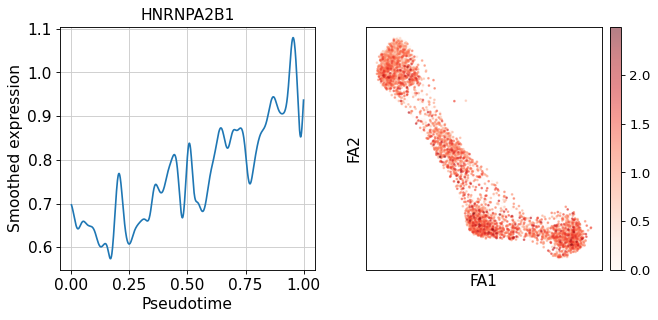

In [42]:
gene_name = 'HNRNPA2B1'
fig = plot_correlation(gene_name)
fig.savefig(f'./output/M132TS__pseudotime_trend__{gene_name}.pdf')

In [43]:
from scipy.stats import spearmanr

log_frequency = 200

spearman_correlations = []
spearman_pvals = []
total_expressions = []

for i, gene_name in enumerate(expressed_splicing_factor_gene_symbols):
    
    gex_array = np.asarray(adata_corr[adata_dpt.obs.index, adata_corr.var.index == gene_name].X.todense()).flatten()
    
    spearman_out = spearmanr(pt_array, gex_array)
    spearman_correlations.append(spearman_out.correlation)
    spearman_pvals.append(spearman_out.pvalue)
    total_expressions.append(np.sum(gex_array))
    
    if i % log_frequency == 0:
        log_info(f'Processing {i} ...')

Processing 0 ...
Processing 200 ...
Processing 400 ...
Processing 600 ...


In [44]:
# BH correction
from statsmodels.stats.multitest import multipletests

_, spearman_pvals_adj, _, _ = multipletests(
    spearman_pvals,
    alpha=0.10,
    method='fdr_bh')

In [45]:
# generate concatenated GO terms
concat_go_terms = []
for gene_name in expressed_splicing_factor_gene_symbols:
    concat_go_term = ', '.join(
        sorted(set(expressed_splicing_factor_df[expressed_splicing_factor_df['SYMBOL'].values == gene_name]['GO NAME'].values)))
    concat_go_terms.append(concat_go_term)

In [46]:
# make a dataframe
splicing_factors_df = pd.DataFrame({
    'gene_names': expressed_splicing_factor_gene_symbols,
    'total_expression': total_expressions,
    'go_terms': concat_go_terms,
    'pseudotime_spearman_corr': spearman_correlations,
    'pseudotime_spearman_pval': spearman_pvals,
    'pseudotime_spearman_pval_adj': spearman_pvals_adj,
})

In [47]:
splicing_factors_df = splicing_factors_df.sort_values(by='pseudotime_spearman_corr', axis=0, ascending=False)
splicing_factors_df.reset_index(drop=True)

,gene_names,total_expression,go_terms,pseudotime_spearman_corr,pseudotime_spearman_pval,pseudotime_spearman_pval_adj
0,SRRT,912.897095,mRNA processing,0.425633,9.236583e-198,1.988944e-195
1,HNRNPLL,589.650940,"mRNA processing, positive regulation of RNA sp...",0.387855,1.097383e-161,1.772273e-159
2,CD2BP2,542.602600,"RNA splicing, mRNA processing, spliceosomal tr...",0.352851,3.041825e-132,3.275031e-130
3,UBL5,2888.170898,"mRNA splicing, via spliceosome",0.331936,2.400952e-116,2.215735e-114
4,RPS26,4065.374023,negative regulation of RNA splicing,0.273559,3.655458e-78,2.623806e-76
...,...,...,...,...,...,...
641,EEF1D,8713.843750,mRNA transcription,-0.244223,3.460091e-62,1.862682e-60
642,EIF3E,2938.950195,"nuclear-transcribed mRNA catabolic process, no...",-0.325263,1.575115e-111,1.271906e-109
643,NPM1,6245.494629,"negative regulation of mRNA splicing, via spli...",-0.361814,1.951403e-139,2.521213e-137
644,PABPC1,5736.208984,"RNA splicing, mRNA polyadenylation, mRNA proce...",-0.564249,0.000000e+00,0.000000e+00


In [48]:
splicing_factors_df.to_csv('./output/M132TS__splicing_factor_corr.csv')

## CD45 isoforms linear regression analysis

In [49]:
pred_transcript_names = [
    'manual__PTPRC_ABC',
    'manual__PTPRC_BC',
    'manual__PTPRC_AB',
    'manual__PTPRC_B',
    'manual__PTPRC_O',
]

In [50]:
adata_gex = adata_short_raw[adata_dpt.obs.index].copy()

In [51]:
adata_long_norm = adata_long_raw[adata_dpt.obs.index].copy()

In [52]:
y = np.asarray(adata_long_norm[:, pred_transcript_names].X.todense())

In [53]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score, explained_variance_score

ev_score_list = []

for gene_name in expressed_splicing_factor_gene_symbols:

    x = np.asarray(adata_gex[:, gene_name].X.todense()).flatten()
    fit = RidgeCV().fit(x[:, None], y)
    y_pred = fit.predict(x[:, None])
    
    ev = explained_variance_score(y, y_pred)
    ev_score_list.append(ev)

In [54]:
# make a dataframe
splicing_factors_ptprc_df = pd.DataFrame({
    'gene_names': expressed_splicing_factor_gene_symbols,
    'total_expression': total_expressions,
    'go_terms': concat_go_terms,
    'ptprc_isoforms_explained_variance_score': ev_score_list,
})

In [55]:
splicing_factors_ptprc_df = splicing_factors_ptprc_df.sort_values(
    by='ptprc_isoforms_explained_variance_score', axis=0, ascending=False)
splicing_factors_ptprc_df = splicing_factors_ptprc_df.reset_index(drop=True)

In [56]:
splicing_factors_ptprc_df

,gene_names,total_expression,go_terms,ptprc_isoforms_explained_variance_score
0,HNRNPLL,589.650940,"mRNA processing, positive regulation of RNA sp...",0.009677
1,SRRT,912.897095,mRNA processing,0.008364
2,RPS13,13153.289062,negative regulation of RNA splicing,0.008352
3,RPS26,4065.374023,negative regulation of RNA splicing,0.007751
4,TMBIM6,2187.671875,negative regulation of RNA splicing,0.006953
...,...,...,...,...
641,SMN2,2.630117,"RNA splicing, mRNA processing",0.000011
642,RAVER2,2.346419,"regulation of alternative mRNA splicing, via s...",0.000010
643,ELAVL4,2.333775,"3'-UTR-mediated mRNA stabilization, RNA splici...",0.000010
644,RBM20,2.555964,"RNA splicing, mRNA processing, positive regula...",0.000010


In [57]:
splicing_factors_ptprc_df.to_csv('./output/M132TS__splicing_factor_PTPRC.csv')